<h4>Build the solutions on the COMPAS data<h4>


<h5>Import libraries<h5>

In [2]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

<h5>Build the Parity and LR functions<h5>

In [3]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on

def s_parity(test_data, predictors, prediction_df, sensitive_attr, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: outcome
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]==0]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]==1]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 0)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 1)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [4]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def logistic_regression(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(class_weight=None, max_iter=100)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

<h5>Build original LR model to get OG parity value<h5>

In [5]:
compas_df = pd.read_csv('compas-scores-two-years.csv', header = 0)

In [6]:
compas_df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


<h5>Basic Information about the dataset<h5>

In [7]:
#Count the number of unique values of specific columns
print(compas_df['race'].unique())

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']


In [8]:
compas_df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [9]:
compas_df.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [10]:
compas_df.duplicated().sum

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
7209    False
7210    False
7211    False
7212    False
7213    False
Length: 7214, dtype: bool>

<h5>After dropping what I think are unnecessary columns, I now need to group columns based on their value<h5>

In [11]:
#Group the race columns together into POC and non-POC
compas_df['race'] = compas_df['race'].apply(lambda x: 'Non-POC' if x == 'Caucasian' else 'POC')

In [12]:
compas_df['race'].unique()

array(['POC', 'Non-POC'], dtype=object)

In [13]:
#Convert the columns for the c_jail_in and c_jail_out into a single column called: time_in_jail
compas_df['c_jail_in'] = pd.to_datetime(compas_df['c_jail_in'])
compas_df['c_jail_out'] = pd.to_datetime(compas_df['c_jail_out'])


In [14]:
# Calculate the difference in days between 'c_jail_out' and 'c_jail_in'
compas_df['jail_stay_days'] = (compas_df['c_jail_out'] - compas_df['c_jail_in']).dt.days

In [15]:
#Convert the Custody columns to a single column with a time 
compas_df['in_custody'] = pd.to_datetime(compas_df['in_custody'])
compas_df['out_custody'] = pd.to_datetime(compas_df['in_custody'])

In [16]:
#Calculate the difference for the new column
compas_df['custody_time'] = (compas_df['out_custody'] - compas_df['in_custody']).dt.days

In [17]:
#need to remove a bunch of columns to keep
cols_to_keep = ['race','priors_count','is_recid','c_charge_desc','c_charge_degree','juv_other_count','juv_fel_count','juv_misd_count','decile_score','jail_stay_days']
compas_df = compas_df.loc[:,cols_to_keep]

In [18]:
#Group the type of crime committed into a group 
drug_columns = [
 'Possession of Cocaine',
 'Possession of Cannabis',
 'Poss 3,4 MDMA (Ecstasy)',
 'Poss3,4 Methylenedioxymethcath',
 'Possession Of Heroin',
 'Possession Of Methamphetamine',
 'Pos Cannabis W/Intent Sel/Del'
 'Possess Cannabis/20 Grams Or Less',
'Possession of Oxycodone',
 'Poss Tetrahydrocannabinols',
 'Possess Drug Paraphernalia',
'Sell Conterfeit Cont Substance',
 'Poss Cocaine/Intent To Del/Sel',
 'Deliver Cocaine',
 'Possession Of Alprazolam',
 'Possession of Morphine',
 'Poss Contr Subst W/o Prescript',
 'Poss Pyrrolidinovalerophenone',
 'Solicit Purchase Cocaine',
 'Possession Of Carisoprodol',
 'Deliver 3,4 Methylenediox',
 'Possession of Ethylone',
 'Consp Traff Oxycodone 28g><30k',
 'Deliver Alprazolam',
 'Manufacture Cannabis',
 'Deliver Cannabis',
 'Deliver Cocaine 1000FT Church',
 'Possession of Hydromorphone',
 'Delivery of 5-Fluoro PB-22',
 'Pos Cannabis For Consideration',
 'Traffick Amphetamine 28g><200g',
 'Poss Of Controlled Substance',
 'Del of JWH-250 2-Methox 1-Pentyl',
 'Purchasing Of Alprazolam',
 'Possession Of Lorazepam',
 'Poss of Methylethcathinone',
 'Possession Of Buprenorphine',
 'Delivery of Heroin',
 'Poss Trifluoromethylphenylpipe',
 'Possession of Hydrocodone',
 'Possession of Butylone',
 'Sale/Del Cannabis At/Near Scho',
 'Sel/Pur/Mfr/Del Control Substa',
 'Poss Drugs W/O A Prescription',
 'Poss of Cocaine W/I/D/S 1000FT Park',
 'Solicit Deliver Cocaine',
 'Purchase Cannabis',
 'Possession Of Diazepam',
 'Deliver Cocaine 1000FT Store',
 'Possession of Codeine',
 'Traffick Hydrocodone   4g><14g',
 'Poss/Sell/Del Cocaine 1000FT Sch',
 'Poss/pur/sell/deliver Cocaine',
 'Del Morphine at/near Park',
 'Possess Tobacco Product Under 18',
 'Traff In Cocaine <400g>150 Kil',
 'Poss Meth/Diox/Meth/Amp (MDMA)',
 'Possession Of Phentermine',
 'Poss Of RX Without RX',
 'Possession Of 3,4Methylenediox',
 'Obtain Control Substance By Fraud',
 'Poss Pyrrolidinovalerophenone W/I/D/S',
 'Solicit To Deliver Cocaine',
 'Pos Methylenedioxymethcath W/I/D/S',
 'Poss Of 1,4-Butanediol',
 'Traffick Oxycodone     4g><14g',
 'Del 3,4 Methylenedioxymethcath',
 'Possession Of Amphetamine',
 'Del Cannabis At/Near Park',
 'Poss/Sell/Del/Man Amobarbital',
 'Possession of LSD',
 'Possession Of Cocaine',
 'Possess Cannabis 1000FTSch',
 'Consp Traff Oxycodone  4g><14g',
 'Delivery Of Drug Paraphernalia',
 'Possession Of Fentanyl',
 'Del Cannabis For Consideration',
 'Possession Of Paraphernalia',
 'Conspiracy to Deliver Cocaine',
 'Poss Oxycodone W/Int/Sell/Del',
 'Poss Pyrrolidinobutiophenone',
 'Sell/Man/Del Pos/w/int Heroin',
 'Purchase/P/W/Int Cannabis',
 'Deliver Cocaine 1000FT School',
 'Possession of Methadone',
 'Possession Of Clonazepam',
 'Possession Of Anabolic Steroid',
 'Purchase Of Cocaine',
 'Deliver Cocaine 1000FT Park',
 'Possession of XLR11'
 'Pos Cannabis W/Intent Sel/Del',
 'Possess Cannabis/20 Grams Or Less',
 'Sale/Del Counterfeit Cont Subs',
 'Poss Alprazolam W/int Sell/Del',
 'Possession of Benzylpiperazine',
 'Poss/Sell/Deliver Clonazepam',
 'Deliver Cannabis 1000FTSch',
 'Sell Cannabis',
 'Armed Trafficking in Cannabis',
 'Possess Controlled Substance',
 'Attempted Deliv Control Subst'
]
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(drug_columns, 'drug_offense')

In [19]:
#Code the Assault Columns
assault_columns = [
'Aggravated Assault w/Firearm',
'Felony Battery w/Prior Convict',
 'Battery',
 'Battery on Law Enforc Officer',
 'Viol Injunct Domestic Violence',
 'Aggravated Battery / Pregnant',
 'Burglary Dwelling Assault/Batt',
 'Felony Battery (Dom Strang)',
 'Aggravated Assault W/Dead Weap',
 'Assault',
 'Burglary Conveyance Assault/Bat',
 'Aggravated Assault W/dead Weap',
 'Child Abuse',
 'Aggrav Battery w/Deadly Weapon',
 'Aggravated Battery (Firearm/Actual Possession)',
 'Burglary With Assault/battery',
 'Resist Officer w/Violence',
 'Battery On Parking Enfor Speci',
 'Viol Prot Injunc Repeat Viol',
 'Aggravated Battery',
 'Aggravated Assault',
 'Viol Pretrial Release Dom Viol',
 'Manslaughter W/Weapon/Firearm',
 'Arson II (Vehicle)',
 'Battery on a Person Over 65',
 'Felony Battery',
 'Fighting/Baiting Animals',
 'Battery Emergency Care Provide',
 'Aggravated Assault W/o Firearm',
 'Carjacking with a Firearm',
 'Neglect Child / Bodily Harm',
 'Strong Armed  Robbery',
 'Felony Batt(Great Bodily Harm)',
 'Agg Assault Law Enforc Officer',
 'Agg Assault W/int Com Fel Dome',
 'Aggr Child Abuse-Torture,Punish',
 'D.U.I. Serious Bodily Injury',
 'Burglary Structure Assault/Batt',
 'Shoot In Occupied Dwell',
 'Battery On A Person Over 65',
 'Viol Injunction Protect Dom Vi',
 'Aggrav Child Abuse-Agg Battery',
 'Aggravated Battery On 65/Older',
 'Aggrav Child Abuse-Causes Harm',
 'Battery On Fire Fighter',
 'Murder in the First Degree',
 'Murder In 2nd Degree W/firearm',
 'Crlty Twrd Child Urge Oth Act',
 'Murder in 2nd Degree',
 'Discharge Firearm From Vehicle',
 'Burglary Assault/Battery Armed',
 'Kidnapping / Domestic Violence',
 'Cruelty to Animals',
 'Shoot Into Vehicle',
 'Battery Spouse Or Girlfriend',
 'Agg Abuse Elderlly/Disabled Adult',
 'Assault Law Enforcement Officer',
 'Aggravated Battery (Firearm)',
 'Agg Battery Grt/Bod/Harm',
 'Throw Deadly Missile Into Veh',
 'Burglary Conveyance Armed',
 'Neglect/Abuse Elderly Person',
 'Solic to Commit Battery',
 'Cruelty Toward Child',
 'Throw Missile Into Pub/Priv Dw',
 'Possess/Use Weapon 1 Deg Felon',
 'Carjacking w/o Deadly Weapon',
 'Abuse Without Great Harm',
 'Arson in the First Degree',
 'Aggress/Panhandle/Beg/Solict'
]

compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(assault_columns, 'assault_offense')

In [20]:
theft_columns = [
 'arrest case no charge',
 'Possession Burglary Tools',
 'Insurance Fraud',
 'Grand Theft in the 3rd Degree',
 'Defrauding Innkeeper $300/More',
'Burglary Structure Unoccup',
 'Attempted Burg/struct/unocc',
 'Petit Theft',
 'Felony Petit Theft',
 'Grand Theft in the 1st Degree',
 'Burglary Unoccupied Dwelling',
 'Robbery / No Weapon',
 'Grand Theft (Motor Vehicle)',
 'Robbery / Weapon',
 'Attempted Robbery  No Weapon',
 'Robbery Sudd Snatch No Weapon',
 'Use Scanning Device to Defraud',
 'Crimin Mischief Damage $1000+',
 'Fraudulent Use of Credit Card',
 'Burglary Dwelling Occupied',
 'Cash Item w/Intent to Defraud',
 'Unemployment Compensatn Fraud',
 'Petit Theft $100- $300',
 'Att Burgl Unoccupied Dwel',
 'Grand Theft Firearm',
 'Failure To Pay Taxi Cab Charge',
 'Attempted Robbery Firearm',
 'Defrauding Innkeeper',
 'Grand Theft of a Fire Extinquisher',
 'Uttering Forged Bills',
 'Robbery W/Firearm',
 'Money Launder 100K or More Dols',
 'Theft/To Deprive',
 'Retail Theft $300 1st Offense',
 'Criminal Mischief>$200<$1000'
 'Grand Theft In The 3Rd Degree',
 'Exploit Elderly Person 20-100K',
 'Ride Tri-Rail Without Paying',
 'Attempt Burglary (Struct)',
 'Burglary Dwelling Armed',
 'Use of Anti-Shoplifting Device',
 'Possess Countrfeit Credit Card',
 'Robbery W/Deadly Weapon',
 'Poss Counterfeit Payment Inst',
 'Poss Anti-Shoplifting Device',
 'Grand Theft (motor Vehicle)',
 'Grand Theft of the 2nd Degree',
 'Attempted Robbery  Weapon',
 'Grand Theft on 65 Yr or Older',
 'PL/Unlaw Use Credit Card',
 'Theft',
 'Uttering Forged Credit Card',
 'Retail Theft $300 2nd Offense',
'Possess w/I/Utter Forged Bills',
 'Attempt Armed Burglary Dwell',
 'Burglary Conveyance Unoccup',
 'Forging Bank Bills/Promis Note',
 'Burglary Conveyance Occupied',
 'Att Burgl Conv Occp',
 'Tresspass Struct/Conveyance',
 'Grand Theft Dwell Property',
 'Burgl Dwel/Struct/Convey Armed',
 'Dealing in Stolen Property',
 'Uttering Worthless Check +$150',
 'Burglary Structure Occupied'
]
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(theft_columns, 'theft_offense')

In [21]:
#Code driving violations
driving_columns = [
 'Felony Driving While Lic Suspd',
 'Driving While License Revoked',
 'Susp Drivers Lic 1st Offense',
 'Operating W/O Valid License',
 'DUI Level 0.15 Or Minor In Veh',
 'Driving License Suspended',
 'Driving Under The Influence',
 'Leaving Acc/Unattended Veh',
 'DUI Property Damage/Injury',
 'Opert With Susp DL 2nd Offens',
 'Failure To Return Hired Vehicle',
 'Agg Fleeing/Eluding High Speed',
 'Fleeing or Eluding a LEO',
 'Felony DUI (level 3)',
 'Drivg While Lic Suspd/Revk/Can',
 'Leave Accd/Attend Veh/Less $50',
 'Leave Acc/Attend Veh/More $50',
 'Fail Register Vehicle',
 'Reckless Driving',
 'Leaving the Scene of Accident',
 'Fail To Secure Load',
 'Expired DL More Than 6 Months',
 'DUI - Enhanced',
 'Lve/Scen/Acc/Veh/Prop/Damage',
 'DUI Blood Alcohol Above 0.20',
 'Poss Unlaw Issue Driver Licenc',
 'DUI - Property Damage/Personal Injury',
 'Counterfeit Lic Plates/Sticker',
 'DWI w/Inj Susp Lic / Habit Off',
 'DUI- Enhanced',
 'Violation License Restrictions',
 'DUI/Property Damage/Persnl Inj',
 'False Motor Veh Insurance Card',
 'DWLS Susp/Cancel Revoked',
 'Oper Motorcycle W/O Valid DL',
 'Opert With Susp DL 2ND Offense',
 'DWLS Canceled Disqul 1st Off',
 'Poss Similitude of Drivers Lic',
 'Felony DUI - Enhanced',
 'Unlaw LicTag/Sticker Attach',
 'Trespass Struct/Conveyance',
 'Felony/Driving Under Influence',
 'Fel Drive License Perm Revoke',
 'Posses/Disply Susp/Revk/Frd DL',
 'License Suspended Revoked',
 'Grand Theft In The 3Rd Degree',
 'Possess Mot Veh W/Alt Vin #',
 'Fail Obey Driv Lic Restrictions',
 'Unlaw Lic Use/Disply Of Others',
 'Poss Unlaw Issue Id',
 'Present Proof of Invalid Insur'
]
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(driving_columns,'driving_offense')

In [22]:
#Code the weapons columns
weapons_columns = [
 'Carrying Concealed Firearm',
 'Poss Wep Conv Felon',
 'Poss Firearm W/Altered ID#',
 'Open Carrying Of Weapon',
 'Poss of Firearm by Convic Felo',
 'Felon in Pos of Firearm or Amm',
 'Carrying A Concealed Weapon',
 'Poss F/Arm Delinq',
 'Possession Firearm School Prop',
 'Trespass Property w/Dang Weap',
 'Exhibition Weapon School Prop',
 'Trespass Structure w/Dang Weap',
]
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(weapons_columns,'weapons_offense')

In [23]:
#Code the sex columns
sex_columns = [
 'Lewd/Lasc Battery Pers 12+/<16',
 'Aggrav Stalking After Injunctn',
 'Lewdness Violation',
 'Lewd or Lascivious Molestation',
 'Sexual Performance by a Child',
 'Voyeurism',
 'Sexual Battery / Vict 12 Yrs +',
 'Sex Offender Fail Comply W/Law',
 'Sex Battery Deft 18+/Vict 11-',
 'Offer Agree Secure For Lewd Act',
 'Prostitution/Lewdness/Assign',
 'Prostitution/Lewd Act Assignation',
 'Lewd Act Presence Child 16-',
 'Soliciting For Prostitution',
 'Video Voyeur-<24Y on Child >16',
 'Felony Committing Prostitution',
 'Use Computer for Child Exploit',
 'Fail Sex Offend Report Bylaw',
 'Lewd/Lasciv Molest Elder Persn',
 'Prostitution',
 'Aide/Abet Prostitution Lewdness',
 'Computer Pornography',
 'Sex Batt Faml/Cust Vict 12-17Y',
 'Possession Child Pornography',
 'Live on Earnings of Prostitute',

]
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(sex_columns,'sex_offense')

In [24]:
#Code the other columns
other_columns = [
 'Introduce Contraband Into Jail',
 'Tampering With Physical Evidence',
 'Att Tamper w/Physical Evidence',
 'Agg Fleeing and Eluding',
 'Unlaw Use False Name/Identity',
 'Uttering a Forged Instrument',
 'False Name By Person Arrest',
 'Flee/Elude LEO-Agg Flee Unsafe',
 'Fail To Redeliv Hire/Leas Prop',
 'False Ownership Info/Pawn Item',
 'Crim Use of Personal ID Info',
 'Resist/Obstruct W/O Violence',
 'Disorderly Intoxication',
 'Fail To Obey Police Officer',
 'nan',
 'Fleeing Or Attmp Eluding A Leo',
 'Criminal Mischief',
 'False Imprisonment',
 'Prowling/Loitering',
 'Throw In Occupied Dwell',
 'Unauth Poss ID Card or DL',
 'Corrupt Public Servant',
 'Tamper With Witness/Victim/CI',
 'Exposes Culpable Negligence',
 'False Bomb Report',
 'Trespassing/Construction Site',
 'Neglect Child / No Bodily Harm',
 'Criminal Mischief Damage <$200',
 'Disorderly Conduct',
 'Violation of Injunction Order/Stalking/Cyberstalking',
 'Obstruct Fire Equipment',
 'Simulation of Legal Process',
 'Depriv LEO of Protect/Communic',
 'Stalking',
 'Trespass Structure/Conveyance',
 'Crim Attempt/Solicit/Consp',
 'Intoxicated/Safety Of Another',
 'Gambling/Gamb Paraphernalia',
 'Unauthorized Interf w/Railroad',
 'Restraining Order Dating Viol',
 'Culpable Negligence',
 'Criminal Mischief>$200<$1000',
 'Sound Articles Over 100',
 'Disrupting School Function',
 'Carry Open/Uncov Bev In Pub',
 'Poss Cntrft Contr Sub w/Intent',
 'Refuse to Supply DNA Sample',
 'Stalking (Aggravated)',
 'Extradition/Defendants',
 'Refuse Submit Blood/Breath Test',
 'Trespass Other Struct/Conve',
 'Threat Public Servant',
 'Use Of 2 Way Device To Fac Fel',
 'Escape',
 'Hiring with Intent to Defraud',
 'Solicitation On Felony 3 Deg',
 'Sell or Offer for Sale Counterfeit Goods',
 'Crim Use Of Personal Id Info',
 'Fail To Redeliver Hire Prop',
 'Unl/Disturb Education/Instui',
 'Violation Of Boater Safety Id',
 'Contribute Delinquency Of A Minor',
 'Imperson Public Officer or Emplyee',
 'Tamper With Victim',
 'Compulsory Sch Attnd Violation',
 'Aiding Escape',
 'Giving False Crime Report',
 'Trans/Harm/Material to a Minor',
 'Harass Witness/Victm/Informnt',
 'Interference with Custody',
 'Traffic Counterfeit Cred Cards',
 'Tampering with a Victim',
 'Offn Against Intellectual Prop',
 'Interfere W/Traf Cont Dev RR',
 'Tresspass in Structure or Conveyance',
 'Attempted Burg/Convey/Unocc',
 'Att Burgl Struc/Conv Dwel/Occp',
 'Fabricating Physical Evidence',
 'DOC/Cause Public Danger',
 'Contradict Statement',
 'Lease For Purpose Trafficking',
 'Bribery Athletic Contests',
 'Crim Attempt/Solic/Consp',
 'Trespass Private Property',
 'Unauth C/P/S Sounds>1000/Audio',
 'Obstruct Officer W/Violence',
 'Cause Anoth Phone Ring Repeat',
 'Tamper With Witness',
 'Harm Public Servant Or Family',
 'Consume Alcoholic Bev Pub',
 'Misuse Of 911 Or E911 System',
 'Accessory After the Fact',
 'Structuring Transactions',
 'Principal In The First Degree',
 'False Info LEO During Invest',
 'Littering',
 'Criminal Attempt 3rd Deg Felon',
 'Possess Weapon On School Prop',
 'Possession of Alcohol Under 21',
 'Unlicensed Telemarketing',
 'Issuing a Worthless Draft',
 'Fraud Obtain Food or Lodging',
 'Falsely Impersonating Officer',
 'Poss of Vessel w/Altered ID NO',
 'Conspiracy Dealing Stolen Prop',
 'False 911 Call',
 'Unlawful Conveyance of Fuel',
 'Fail Register Career Offender',
 'Lewd/Lasc Exhib Presence <16yr',
 'Dealing In Stolen Property',
 'Trespass On School Grounds',
 'Offer Agree Secure/Lewd Act',
 'Trespass Struct/Convey Occupy',
 'Compulsory Attendance Violation',
 'Unlawful Use Of Police Badges',
 'Manage Busn W/O City Occup Lic',
 'Sel Etc/Pos/w/Int Contrft Schd',
 'Alcoholic Beverage Violation-FL'
]
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(other_columns,'other_offense')

In [25]:
#Group remaining values
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace(['Pos Cannabis W/Intent Sel/Del','Possession of XLR11'],'drug_offense')

In [26]:
compas_df['c_charge_desc'] = compas_df['c_charge_desc'].replace([None],'other_offense')

In [27]:
compas_df['c_charge_desc'].unique()

array(['assault_offense', 'drug_offense', 'theft_offense',
       'driving_offense', 'other_offense', 'sex_offense',
       'weapons_offense'], dtype=object)

In [28]:
compas_df.columns

Index(['race', 'priors_count', 'is_recid', 'c_charge_desc', 'c_charge_degree',
       'juv_other_count', 'juv_fel_count', 'juv_misd_count', 'decile_score',
       'jail_stay_days'],
      dtype='object')

<h5>Build the Model with LR and OG parity <h5>

In [29]:
#Encode the columns and the dataset
columns_to_encode = [
    'race',
    'c_charge_degree',
    'c_charge_desc'
]

encoded_data = pd.get_dummies(compas_df,columns=columns_to_encode,drop_first=True)

In [30]:
compas_df['race'].unique()

array(['POC', 'Non-POC'], dtype=object)

In [31]:
#Drop the rows with missing values
encoded_data = encoded_data.dropna()

In [32]:
encoded_data

,priors_count,is_recid,juv_other_count,juv_fel_count,juv_misd_count,decile_score,jail_stay_days,race_POC,c_charge_degree_M,c_charge_desc_driving_offense,c_charge_desc_drug_offense,c_charge_desc_other_offense,c_charge_desc_sex_offense,c_charge_desc_theft_offense,c_charge_desc_weapons_offense
0,0,0,0,0,0,1,0.0,True,False,False,False,False,False,False,False
1,0,1,0,0,0,3,10.0,True,False,False,False,False,False,False,False
2,4,1,1,0,0,4,1.0,True,False,False,True,False,False,False,False
5,0,0,0,0,0,1,1.0,True,True,False,False,False,False,False,False
6,14,1,0,0,0,6,6.0,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,0,0,0,0,7,1.0,True,False,False,True,False,False,False,False
7210,0,0,0,0,0,3,1.0,True,False,True,False,False,False,False,False
7211,0,0,0,0,0,1,1.0,True,False,False,False,False,False,False,False
7212,3,0,0,0,0,2,1.0,True,True,False,False,False,False,False,False


In [80]:
#Initialize all the different columns
predictors = ['race_POC','priors_count', 'juv_other_count', 'juv_fel_count',
       'juv_misd_count', 'decile_score', 'jail_stay_days', 'c_charge_degree_M',
       'c_charge_desc_driving_offense', 'c_charge_desc_drug_offense',
       'c_charge_desc_other_offense', 'c_charge_desc_sex_offense',
       'c_charge_desc_theft_offense', 'c_charge_desc_weapons_offense']
target_var = 'is_recid'

In [81]:
#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

In [83]:
num_missing_rows = encoded_data.isna().any(axis=1).sum()
num_missing_rows

0

In [84]:
#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

67.94500723589


In [85]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a POC
#Protected Group is everyone who is a non-POC
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['is_recid_new'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['race_POC']==1]))
total_priv = (len(concat_df[concat_df['race_POC']==0]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['is_recid_new'] == 1) & (concat_df['race_POC'] == 1)])
total_credit_priv = len(concat_df[(concat_df['is_recid_new'] == 1) & (concat_df['race_POC'] == 0)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')


Statistical Parity: -0.17935


In [96]:
#concat_df: the testing dataframe along with the predicted values appended onto the end of it 
#now I compare the concat_df is_recid_new column to the y_test values and see which ones match up 
#rows that do not match up will be placed in a dataframe and then used to calculate the misclassification rate
ground_truth = pd.DataFrame(y_test, columns=['true_value'])

# Create an empty list to store mismatched rows
misclass_rows = []

# Iterate over each row in concat_df
for index, row in concat_df.iterrows():
    # Get the corresponding row index in ground_truth
    true_value = ground_truth.iloc[index]['true_value']
    # Compare the values in 'is_recid_new' and 'true_value'
    if row['is_recid_new'] != true_value:
        # If values don't match, append the row to misclass_rows
        misclass_rows.append(row)

# Convert the list of mismatched rows to a DataFrame
misclass_rows_df = pd.DataFrame(misclass_rows)

In [ ]:
#Get each of the different total crime groups
#Driving True: 52
print(misclass_rows_df['c_charge_desc_driving_offense'].value_counts())
#Sex True: 3
print(misclass_rows_df['c_charge_desc_sex_offense'].value_counts())
#Theft True: 127
print(misclass_rows_df['c_charge_desc_theft_offense'].value_counts())
#Other True: 37
print(misclass_rows_df['c_charge_desc_other_offense'].value_counts())
#Drug True: 87
print(misclass_rows_df['c_charge_desc_drug_offense'].value_counts())
#Weapons True: 3
print(misclass_rows_df['c_charge_desc_weapons_offense'].value_counts())

In [109]:
#Get the misclassification rates
#443
len(misclass_rows_df)

driving_mis = 52/443
sex_mis = 3/443
theft_mis = 127/443
other_mis = 37/443
drug_mis = 87/443
weapons_mis = 3/443

print(driving_mis, sex_mis, theft_mis, other_mis, drug_mis, weapons_mis)

0.11738148984198646 0.006772009029345372 0.2866817155756208 0.0835214446952596 0.1963882618510158 0.006772009029345372


<h5>Iterative Flipping<h5>

In [39]:
#Need to build a new dataframe for training and testing purposes for iterative flipping
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['is_recid'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

start = time.time()

In [40]:
train_full_df['is_recid'] = train_full_df['is_recid'].replace(True, 1)
train_full_df['is_recid'] = train_full_df['is_recid'].replace(False, 0)

In [41]:
#When flipping the label make sure convert the flip before into its original value
count = 0

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
    print(count)
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['is_recid'] == 1:
      #Flip the label
        train_full_df.at[index, 'is_recid'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'is_recid_new')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'is_recid'] = 1
        count += 1


    #Repeats all the same steps as above but this time if the original label is 2
    elif row['is_recid'] == 0:
        train_full_df.at[index, 'is_recid'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'is_recid_new')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'is_recid'] = 0
        count += 1
      

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316


In [42]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [43]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [44]:
#Flip the top 50% of the list
sorted_indices_list = sorted_indices_list[:int(len(sorted_indices_list)*.2)]

In [45]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
iterative_ranked_parity = []
#Accuracy after every flip
iterative_ranked_acc = []
#Index/row of the flip
iterative_ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'is_recid'] == 1:
      train_full_df.at[row_num, 'is_recid'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'is_recid_new')

      iterative_ranked_flip.append(row_num)
      iterative_ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
      iterative_ranked_parity.append(parity)


  elif train_full_df.at[row_num,'is_recid'] == 0:
      train_full_df.at[row_num, 'is_recid'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'is_recid_new')

      iterative_ranked_flip.append(row_num)
      iterative_ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
      iterative_ranked_parity.append(parity)

In [46]:
#Place the original parity at the beginning of the list
iterative_ranked_parity.insert(0,statistical_parity)

In [47]:
#Store end time
end = time.time()
total_time = end-start

time_taken = []
solution = []

time_taken.append(total_time)
solution.append('Iterative Flipping')

<h5>Uncertainty Reduction<h5>

In [48]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['is_recid'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

start = time.time()

In [49]:
train_full_df_entropy['is_recid'] = train_full_df_entropy['is_recid'].replace(True, 1)
train_full_df_entropy['is_recid'] = train_full_df_entropy['is_recid'].replace(False, 0)

In [50]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [51]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [52]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [53]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Getting the top 50% values
ranked_indices_list = ranked_indices_list[:int(len(ranked_indices_list)*.2)]

In [54]:
#After ranking and getting the top 50% points I flip them based on where they are in the list

#Different lists to hold each of the values
entropy_ranked_parity = [statistical_parity]
entropy_ranked_acc = []
entropy_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'is_recid'] == 1:
    train_full_df_entropy.at[row_num,'is_recid'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'is_recid_new')

    entropy_ranked_flip.append(row_num)
    entropy_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC','is_recid_new')
    entropy_ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'is_recid'] == 0:
    train_full_df_entropy.at[row_num,'is_recid'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'is_recid_new')

    entropy_ranked_flip.append(row_num)
    entropy_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC','is_recid_new')
    entropy_ranked_parity.append(parity)


end = time.time()
total_time = end - start

In [55]:
time_taken.append(total_time)
solution.append('Uncertainty Reduction')

<h5>Maximum Expected Utility<h5>

In [56]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['is_recid'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

start = time.time()

In [57]:
train_full_df_MEU['is_recid'] = train_full_df_MEU['is_recid'].replace(True, 1)
train_full_df_MEU['is_recid'] = train_full_df_MEU['is_recid'].replace(False, 0)

In [58]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [59]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [60]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'is_recid'])
  row_index.append(index)

In [61]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 0:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [62]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['is_recid'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'is_recid'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'is_recid_new')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'is_recid'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['is_recid'] == 0:
        copy_train_full_df.at[index, 'is_recid'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'is_recid_new')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC','is_recid_new')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'is_recid'] = 0

In [63]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 0:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [64]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [65]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [66]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

#Get the top 20% of points
sorted_index_list = sorted_index_list[:int(len(sorted_index_list)*.2)]

In [67]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'is_recid'] == 1:
    train_full_df_MEU.at[row_num,'is_recid'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'is_recid_new')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'is_recid'] == 0:
    train_full_df_MEU.at[row_num,'is_recid'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'is_recid_new')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
    MEU_ranked_parity.append(parity)




In [68]:
#Convert each of the tuples into lists
meu_ranked_indices_list = list(sorted_index_list)
meu_ranked_eu_list = list(MEU_ranked_parity)

#Time Taken
end = time.time()
total_time = end - start

time_taken.append(total_time)
solution.append('MEU')

<h5>Random Flipping<h5>

In [69]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['is_recid'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

start = time.time()

In [70]:
train_full_df_random['is_recid'] = train_full_df_random['is_recid'].replace(True, 1)
train_full_df_random['is_recid'] = train_full_df_random['is_recid'].replace(False, 0)

In [71]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'is_recid'
budget = int(len(train_full_df_random)*.2)

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'is_recid_new')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC','is_recid_new')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'is_recid_new')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'race_POC', 'is_recid_new')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




In [72]:
end = time.time()

total_time = end - start
time_taken.append(total_time)
solution.append('Random Flipping')

<h4>Graph the changes in parity for 1k datapoints<h4>

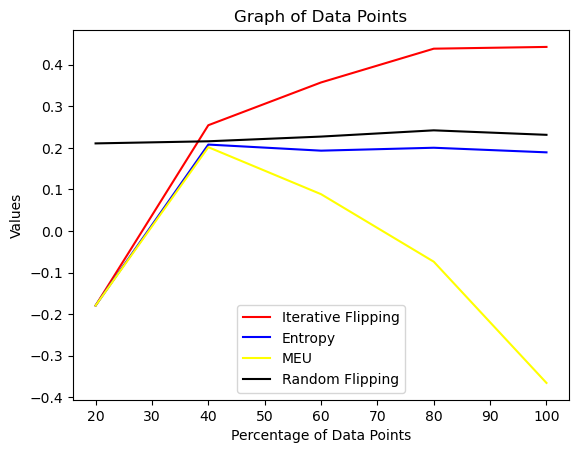

In [73]:
# Calculate the total number of data points
datapoints_iterative = len(iterative_ranked_parity)
datapoints_entropy = len(entropy_ranked_parity)
datapoints_meu = len(meu_ranked_eu_list)
datapoints_random = len(random_list_parity)

# Calculate the indices for the 5 points
indices_iterative = [int(i * datapoints_iterative / 5) for i in range(0, 5)]
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_meu = [int(i * datapoints_meu / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]

# Extract the values at these indices
values_iterative = [iterative_ranked_parity[index] for index in indices_iterative]
values_entropy = [entropy_ranked_parity[index] for index in indices_entropy]
values_meu = [meu_ranked_eu_list[index] for index in indices_meu]
values_random = [random_list_parity[index] for index in indices_random]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_iterative, label='Iterative Flipping', color='Red')
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_meu, label='MEU', color='Yellow')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Black')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h5>Observe the misclassification rates of each of the different crime groups<h5>
<h5>To do this I will use the OG parity and LR model to see the misclassification rates<h5>

In [75]:
#Before calculating the misclassification rates, I see which groups are over or under represented in this dataset
compas_df['c_charge_desc'].value_counts()

c_charge_desc
theft_offense      2234
assault_offense    2037
drug_offense       1265
driving_offense     932
other_offense       616
sex_offense          66
weapons_offense      64
Name: count, dtype: int64

<h5>Each Crime Represented<h5>
<ul>
<li>Theft: 2243</li>
<li>Assualt: 2037</li>
<li>Drug: 1265</li>
<li>Driving: 932</li>
<li>Other: 616</li>
<li>Sex: 66</li>
<li>Weapons: 64</li>
</ul>